# plot waveforms from different clusters

In [15]:
from pyrocko import util, model, io, trace, moment_tensor, gmtpy,orthodrome
from pyrocko import orthodrome as od
from pyrocko.client import catalog
from pyrocko.automap import Map
import pyrocko.moment_tensor as pmt
from pyrocko.plot import mpl_color
from pyrocko.guts import load
# from seiscloud import plot as scp
# from seiscloud import cluster as scc
import numpy as np
import os
# import shutil
import matplotlib.pyplot as plt
import pygmt

In [16]:
# select clusty folder
workdir='../../clusty_flegrei/'
switch_VT=True               # CHANGE

if switch_VT:
    catdir=os.path.join(workdir,'results_VT')
else: 
    catdir=os.path.join(workdir,'results_VLP')
catname=os.path.join(catdir,'cat_trimmed_mean_ccs_dbscan_comb_0.150_3.yaml')

clusty_events=model.load_events(catname,format='yaml')


In [17]:
# create dictionary to devide events per clusters
cluster_number=[]
cluster_color=[]
for ev in clusty_events:
    if not ev.extras['cluster_number'] in cluster_number:
        cluster_number.append(ev.extras['cluster_number'])
        cluster_color.append(ev)

cls = {key: [] for key in cluster_number}
for ev in clusty_events:
    cls[ev.extras['cluster_number']].append(ev)

cls_color = {key: [] for key in cluster_number}
for color in cluster_color:
    cls_color[color.extras['cluster_number']].append(color.extras['color'])

if switch_VT:
    del cls[-1]     #remove ev not clustered, only for VT
    del cls_color[-1]

for key in cls:
    print(f'cluster {key} with n ev = {len(cls[key])}')
    print(f'cluster {key} with color {cls_color[key]}\n')

cluster 0 with n ev = 18
cluster 0 with color ['#00A08B']

cluster 2 with n ev = 12
cluster 2 with color ['#6A76FC']

cluster 1 with n ev = 19
cluster 1 with color ['#FD3216']

cluster 4 with n ev = 11
cluster 4 with color ['#620042']

cluster 3 with n ev = 4
cluster 3 with color ['#FF9616']

cluster 5 with n ev = 6
cluster 5 with color ['#328a3e']



In [18]:
# data folder (response removed)
workdir='../'
datadir =  os.path.join(workdir,'DATA_VLP')

# stations list
stationsdir=os.path.join(workdir,'META_DATA')
stationsname=os.path.join(stationsdir,'stations_flegrei_INGV_final_similarity.pf')
stations=model.load_stations(stationsname)

freq_min=0.5
freq_max=2.0

time_window= 20     # s

cluster_selected=4      # CHANGE
cluster=cls[cluster_selected]  # select cluster    
number_of_events= len (cluster)

#dictionary : DICT [ station ] [ event name ]
dict_traces = {key.station: [] for key in stations}
for station in dict_traces:
    dict_traces[station] = {key.name: [] for key in cluster} 

#dictionary containing max amplitude registered at 'station_normalization_name' for each event
dict_stations_max = {key.name: [] for key in cluster}

for targ_ev in cluster:   # loop each event
    event_name=targ_ev.name
    ev_dir = os.path.join(datadir, event_name)
    
    if not os.path.isdir(ev_dir):
        print(event_name, 'missing data dir', ev_dir)
    elif os.path.isdir(ev_dir):
        file_name = os.path.join(ev_dir,event_name + '.mseed' )
        traces = io.load(file_name)
        print(f'reading event: {event_name}')

        station_normalization_name='CBAC'           # CHANGE
        station_counter=0
        for tr in traces:   # normalize traces for each event relative to 'station_normalization_name'
            if tr.channel=='HHZ' and tr.station == station_normalization_name:
                station_counter+=1
                tmp_trace_max= tr.copy()
                tmp_trace_max.lowpass(4,freq_max)
                tmp_trace_max.highpass(4,freq_min)
                tmp_trace_max.chop(tmp_trace_max.tmin + 300 - 2, tmp_trace_max.tmin + 300 + time_window - 2 )
                max_station=np.max(np.abs(tmp_trace_max.ydata) )
                dict_stations_max[event_name]=max_station
        if station_counter != 1:
            print(f'Warning: station_counter = {station_counter}.\nCheck event: {event_name}')

        for tr in traces:
            if tr.channel=='HHZ':   # select HHZ channel
                #print('\nsearch!')
                for key in dict_traces:
                    #print(tr.channel,tr.station,'=?=',key)
                    if key== tr.station:    #  if target station is = to trace station
                        #print('yes!')
                        tmp_trace= tr.copy()
                        tmp_trace.lowpass(4,freq_max)
                        tmp_trace.highpass(4,freq_min)
                        tmp_trace.chop(tmp_trace.tmin + 300 - 2, tmp_trace.tmin + 300 + time_window - 2)
                        tmin_new = util.str_to_time('2000-01-01 00:00:0.000')
                        tmp_trace.shift(tmin_new - tmp_trace.tmin)
                        tmp_trace.ydata /= max_station
                        dict_traces[tr.station][event_name].append(tmp_trace)

reading event: flegrei_2022_11_12_21_37_54
reading event: flegrei_2023_08_27_21_14_23
reading event: flegrei_2023_09_26_06_31_43
reading event: flegrei_2023_09_26_07_10_29
reading event: flegrei_2024_01_21_09_35_04
reading event: flegrei_2024_02_17_18_09_50
reading event: flegrei_2024_04_06_11_59_31
reading event: flegrei_2024_04_27_03_44_56
reading event: flegrei_2024_05_22_06_28_00
reading event: flegrei_2024_07_26_11_46_21
reading event: flegrei_2025_02_16_14_30_02


In [19]:
#dict_traces[station_normalization_name]['flegrei_2025_02_16_14_30_02'][0].snuffle()

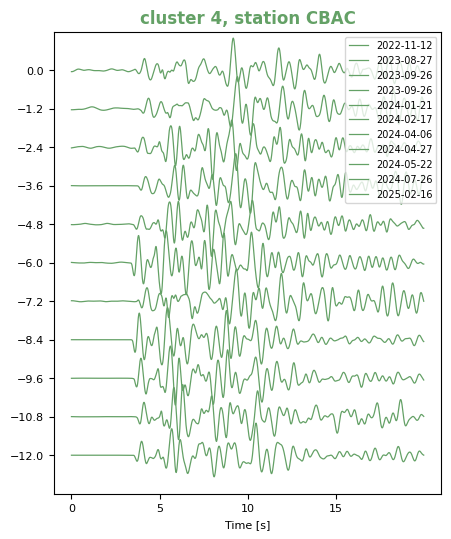

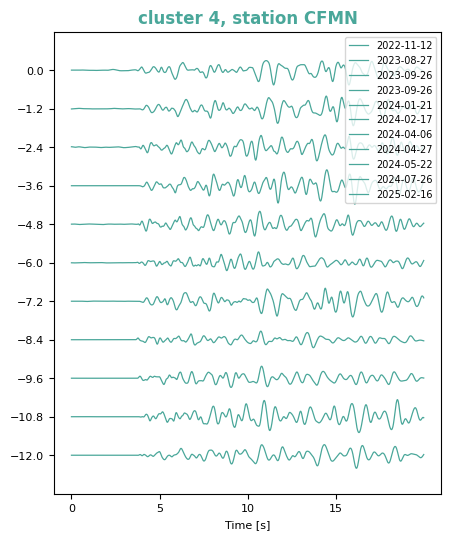

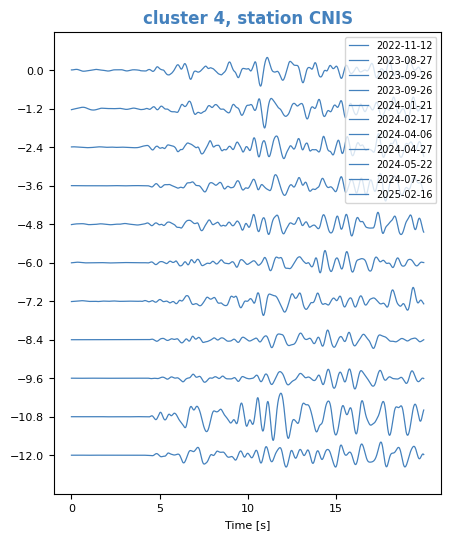

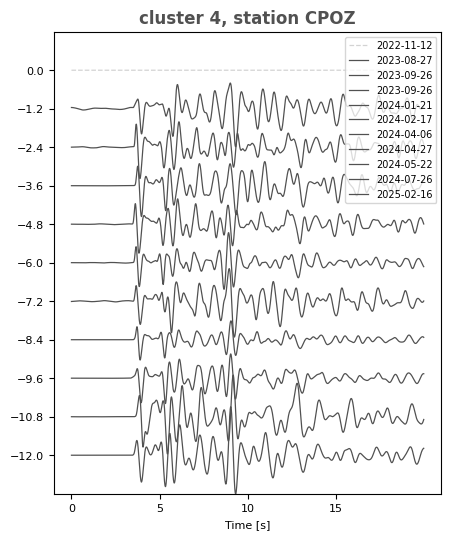

: 

In [ ]:
ref_tr=dict_traces[station_normalization_name]['flegrei_2024_04_27_03_44_56'][0].copy()     # ref: flegrei_2024_04_27_03_44_56

colors = {key.station: [] for key in stations}
colors['CBAC']='#64A166'
colors['CPOZ']='#515151'
colors['CNIS']='#4481BD'
colors['CFMN']='#4AA79A'

# figure dir
plotdir=os.path.join('../PLOTS/CLUSTER_COMPARISON')

zero_trace=np.zeros(len(ref_tr.ydata))
tax_zero=np.arange(ref_tr.tmin,ref_tr.tmax,ref_tr.deltat) - ref_tr.tmin

for station in dict_traces:
    y_shift=0
    plt.figure(f'{station}',figsize=(5, 6))
    plt.title(f'cluster {cluster_selected}, station {station}',color=colors[station],fontweight='bold')
    for ev in dict_traces[station]:
            tr_label=f'{ev[8:12]}-{ev[13:15]}-{ev[16:18]}'
            try:
                trace_plt=dict_traces[station][ev][0]
                tax=np.arange(trace_plt.tmin,trace_plt.tmax,trace_plt.deltat) - ref_tr.tmin
                plt.plot(tax,trace_plt.ydata - y_shift,label=tr_label,color=colors[station],linewidth=0.9)
                y_shift+=1.2
            except:
                plt.plot(tax_zero,zero_trace - y_shift,'--',label=tr_label,color='lightgray',linewidth=0.9)
                y_shift+=1.2
    plt.ylim(- number_of_events * 1.2 , 1.2)
    plt.legend(loc=1,fontsize=7)
    plt.yticks(ticks = list(np.arange(0,- number_of_events * 1.2,-1.2)),fontsize=8)
    plt.xticks(ticks = list(np.arange(0,time_window,5)),fontsize=8)
    plt.xlabel('Time [s]',fontsize=8)
    #
    plt.savefig(plotdir+f'/cluster_{cluster_selected}_{station}_similarity.pdf')